# Assignment Problem 


\begin{alignat}{3}
&\text{Minimize}   &\quad& \sum_{i=1}^{N} \sum_{j=1}^{N} c_{ij} x_{ij} & \\
&\text{subject to} &      & \sum_{j=1}^{N} x_{ij} = 1  &\quad& \forall i = 1, \ldots, N \\
&                  &      & \sum_{i=1}^{N} x_{ij} = 1  &\quad& \forall j = 1, \ldots, N \\
&                  &      & x_{ij} \in \{0, 1\}        &\quad& \forall i, j = 1, \ldots, N
\end{alignat}

### Where:
- $N$ is the number of tasks (and workers).
- $c_{ij}$ is the cost of assigning task $ i $ to worker $ j $.
- $x_{ij}$ is a binary variable, equal to 1 if task $ i $ is assigned to worker $ j $, and 0 otherwise.


### Libraries

In [1]:
import gurobipy as gp
from gurobipy import GRB, quicksum, Model
import matplotlib.pyplot as plt
import numpy as np
import time

### Plotting function

In [2]:
def plot_bounds_over_time(time_data, upper_bounds, lower_bounds):
    """
    Plots the upper and lower bounds over time.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(time_data, lower_bounds, color='red', marker='o', label="Lower Bound")
    plt.plot(time_data, upper_bounds, color='blue', marker='x', label="Upper Bound")
    plt.title('Upper vs Lower Bound over Time', fontsize=14)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Objective Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

### Parameters

In [3]:
cost_matrix = np.array([
    [12, 7, 9],
    [8, 7, 6],
    [7, 17, 12]
])

N = cost_matrix.shape[0]  # Number of tasks/workers
time_limit = 60  # Set a time limit in seconds

### Create the Gurobi Model

In [4]:
m = Model("SimpleAssignment")
m.setParam('TimeLimit', time_limit)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
Set parameter TimeLimit to value 60


### Variables

In [5]:
x = m.addVars(N, N, vtype=GRB.BINARY, name="x")

### Model


In [6]:
# ---------------------  Objective Function ---------------------
m.setObjective(quicksum(cost_matrix[i, j] * x[i, j] for i in range(N) for j in range(N)), GRB.MINIMIZE)

# ---------------------  Constraints ---------------------
# 1) Each task assigned to exactly one worker
m.addConstrs((x.sum(i, '*') == 1 for i in range(N)), name="TaskAssignment")

# 2) Each worker assigned to exactly one task
m.addConstrs((x.sum('*', j) == 1 for j in range(N)), name="WorkerAssignment")

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>}

### Callback for Collecting Bounds

In [7]:
def data_cb(model, where):
    if where == GRB.Callback.MIP:
        cur_obj = model.cbGet(GRB.Callback.MIP_OBJBST)
        cur_bd = model.cbGet(GRB.Callback.MIP_OBJBND)
        if model._obj != cur_obj or model._bd != cur_bd:
            model._obj = cur_obj
            model._bd = cur_bd
            model._data.append([time.time() - model._start, cur_obj, cur_bd])

### Solve the Model and Collect Data

In [8]:
m._obj, m._bd, m._data = None, None, []
m._start = time.time()
m.optimize(callback=data_cb)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6 rows, 9 columns and 18 nonzeros
Model fingerprint: 0xf7b8a409
Variable types: 0 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 6 rows, 9 columns, 18 nonzeros
Variable types: 0 continuous, 9 integer (9 binary)
Found heuristic solution: objective 20.0000000

Root relaxation: cutoff, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        20.00000   20.00000  0.00%     -    0

### Process collected data

In [9]:
time_data = [entry[0] for entry in m._data]
upper_bounds = [entry[1] for entry in m._data]
lower_bounds = [entry[2] for entry in m._data]

### Plot

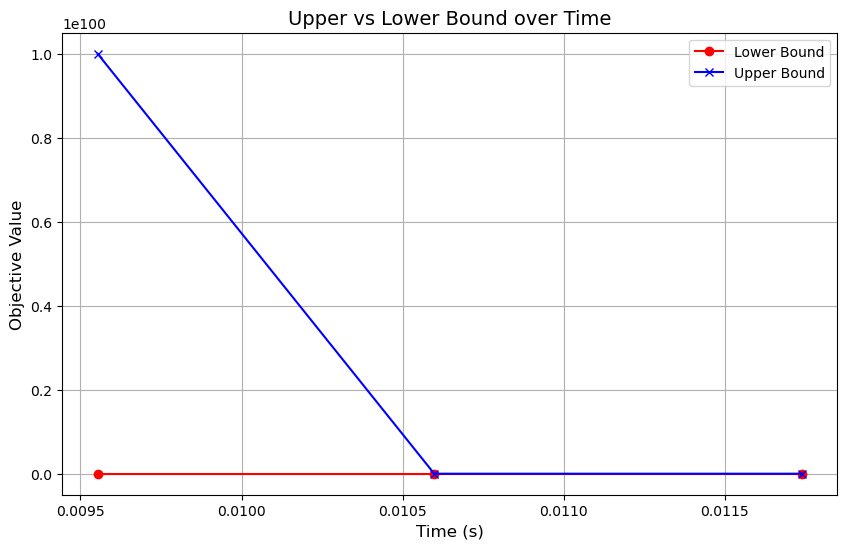

In [10]:
plot_bounds_over_time(time_data, upper_bounds, lower_bounds)

### Display Solution

In [11]:
print("\n" + "#" * 70)
if m.SolCount > 0:
    print(f"Objective Value: {round(m.ObjVal, 2)}")
    print(f"Final Upper Bound: {upper_bounds[-1]}")
    print(f"Final Lower Bound: {lower_bounds[-1]}\n")
    print("Assignments:")
    solution = m.getAttr('x', x)
    for i in range(N):
        for j in range(N):
            if solution[i, j] > 0.5:
                print(f"  Task {i} assigned to Worker {j}")
else:
    print("No feasible solution found within time limit.")
print("#" * 70 + "\n")


######################################################################
Objective Value: 20.0
Final Upper Bound: 20.0
Final Lower Bound: 20.0

Assignments:
  Task 0 assigned to Worker 1
  Task 1 assigned to Worker 2
  Task 2 assigned to Worker 0
######################################################################

